# Plotting Script Notebook

This is a notebook that can recreate plots for any dataset outputted from the GP method. This is to serve as an alternative to a plotting script which for some reason is producing memory errors.

In [1]:
import numpy as np
import pandas as pd
import george
import matplotlib.pyplot as plt
import corner
from plotting import plot_folded_lightcurve, plot_lightcurve, plot_steps

def read_chain(file_name, shape):
    """
    Read in result files from the gp method.
    """
    
    new_data = np.genfromtxt(file_name, delimiter=' ')
    
    # data shape can be found as the first commented line in the txt file
    new_data = new_data.reshape(shape)
    
    return new_data

def read_data(filename, datadir="./"):
    """
    Read in light curve data from asteroid.
    """

    data  = pd.read_csv(datadir+filename, header=None, delim_whitespace=False)

    tsample = data[0]
    fsample = data[1]
    flux_err = data[2]
    data_pts = len(tsample)

    return tsample, fsample, flux_err, data_pts

def generate_gp(params, fsample, flux_err):

    """
    Sets up the initial parameters for all the walkers using optimized
    parameter values as starting values. The function generates a
    scattered multivatiate gaussian distribution of starting parameter
    values.

    Parameters
    ----------
    params : list
        List of all kernel parameters.

    Returns
    -------
    p0 : numpy.ndarray
        The initial walker parameters [nwalker, ndim]

    gp : george.gp.GP
        GP kernel set with the optimized parameter values.

    """

    gp_mean, log_amp, gamma, log_period = params

    kernel = np.exp(log_amp) * george.kernels.ExpSine2Kernel(gamma = gamma, log_period = log_period)
    gp = george.GP(kernel, fit_mean=True, mean=gp_mean)
    gp.compute(fsample, flux_err)

    return gp

def plot_steps_from_saved(results, dims=None, data_pts=None):
    fig, ax = plt.subplots(2, 2, figsize=(7,6))
    fig.subplots_adjust(wspace=0.25, hspace=0.3)

    fig.suptitle("Data points: " + str(data_pts))

    axs = [ax[0,0], ax[0,1], ax[1,0], ax[1,1]]

    iterations = np.arange(results.shape[1])

    for i in range(results.shape[2]):
        axs[i].set_xlabel('Step Number')
        axs[i].set_ylabel('{}'.format(dims[i]))

        for j in range(results.shape[0]):
            param = results[j,:,i]
            axs[i].plot(iterations, param, 'k-', alpha=0.3)

    return axs


In [6]:
# assign file names
data_file = "../data/221_lc_49627_to_49787.txt"

sample_file = "../data/221_lc_49627_to_49787.txt_sampled_semi-dense_60days_equal_dist"

results_file =  "test_results.txt"
results_shape=  "100, 100, 4"
days = 60
true_period = 10.433

# read in all the data
data = pd.read_csv(data_file, delimiter=' ',
                 header=None, names=['time','flux'], dtype={'time':float, 'flux':float})

tsample, fsample, flux_err, data_pts = read_data(sample_file)

results_shape = [int(s) for s in results_shape.split(',')]
results = read_chain(results_file, results_shape)


In [7]:
nmodels = 10
npred = 1000
namestr = 'test'

[23  6 15 87 54  1 84 49 83 59]
[ 0.79319723 -2.03008803  1.32687923 -1.52562797]
[ 1.15829183 -2.89931536  0.82806318 -1.93159113]
[ 1.08678311 -2.58107603  1.12240426 -1.82919365]
[ 0.97282194 -2.2537097   0.89292992 -0.27073856]
[ 0.96882408 -2.90120132  1.20442376 -0.90158295]
[ 0.97644793 -2.47354532  1.05828788 -2.02307935]
[ 1.17888006 -2.5732072   1.01543252 -0.27448334]
[ 0.95456674 -2.43964518  1.1961643  -0.96781312]
[ 1.07162707 -2.842923    1.18447449 -0.38795418]
[ 1.25210748 -2.74555184  1.00944432 -0.83238326]
m_all : [[1.05600397 0.9341229  0.958631   ... 1.03238957 1.02970595 0.90547303]
 [1.02466265 0.99784247 0.99483058 ... 0.96622723 1.01240881 1.03008921]]
83


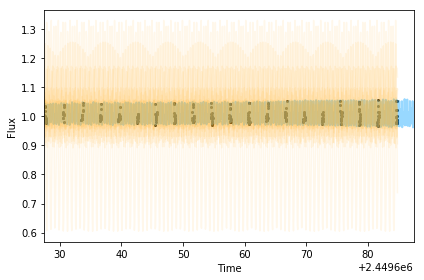

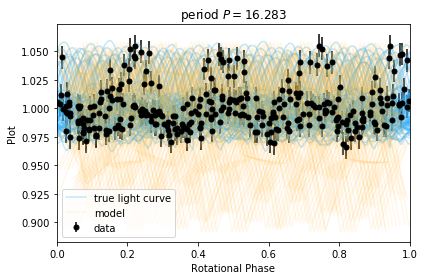

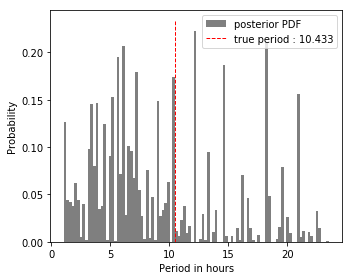

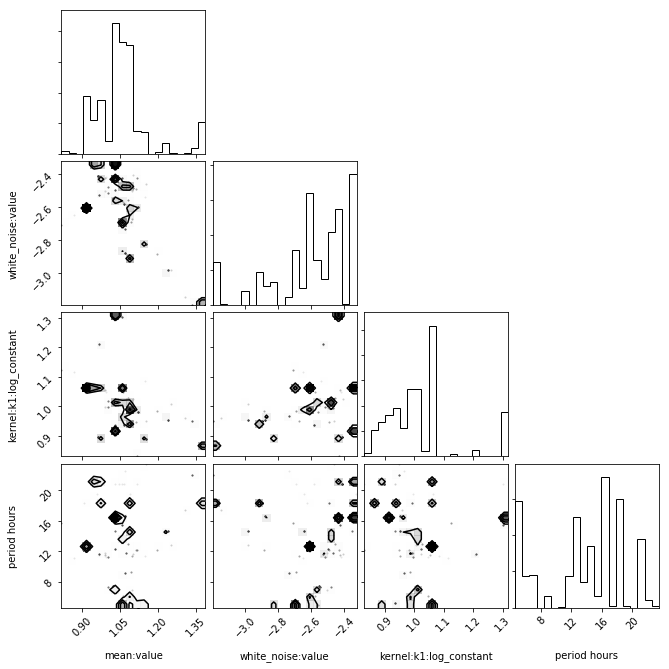

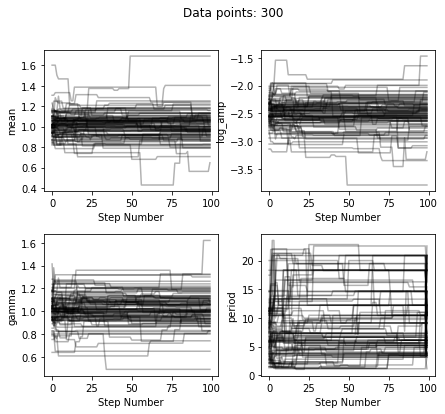

In [8]:
# convert days to points
span = 2880 * days
start_pt = 0

time = np.array(data.time[start_pt:span+start_pt])
flux = np.array(data.flux[start_pt:span+start_pt])

true_lightcurve = [time, flux]

results_flat = results.reshape(results.shape[0]*results.shape[1],results.shape[2])

idx = np.random.choice(np.arange(0, results.shape[0] ,1, dtype=int), size=nmodels)
print(idx)

t_pred = np.linspace(tsample[0], tsample.iloc[-1], npred)
m_all = np.zeros((nmodels, t_pred.shape[0]))


params = [np.mean(fsample), (np.log(fsample.max()-fsample.min())), 1, np.mean(results.T[3])]

gp = generate_gp(params, fsample, flux_err)


# loop through the indices of samples, for each sample from the GP
# conditional on the data points
for i,j in enumerate(idx):
    #only selects from the last step in the chain
    p = results[j, results.shape[1]-1]
    print(p)
    pnew = [p[0], p[1], p[2], p[3]]

    gp.set_parameter_vector(pnew)
    mean_model = gp.sample_conditional(fsample, t_pred)
    m_all[i] = mean_model

print("m_all : " +str(m_all[:2]))
x = np.random.choice(idx)

guess_period = np.exp(results[x,results.shape[1]-1][3])
print(x)


fig, ax = plt.subplots(1, 1, figsize=(6,4))

plot_lightcurve(tsample, fsample, true_lightcurve=true_lightcurve,
                    models=(t_pred, m_all), ax=ax)

plt.tight_layout()
plt.savefig(namestr + "_lc.pdf", format="pdf")

# plot folded light curve
fig, ax = plt.subplots(1, 1, figsize=(6,4))


if true_period:
    ax = plot_folded_lightcurve(tsample, fsample, guess_period, flux_err=0.01,
                      models=[t_pred, m_all[:2]],
                      true_lightcurve=true_lightcurve, ax=ax, use_radians=False)
else:
    ax = plot_folded_lightcurve(tsample, fsample, guess_period, flux_err=flux_err,
                      models=[t_pred, m_all[:2]],
                      true_lightcurve=true_lightcurve, ax=ax, use_radians=False)

plt.tight_layout()
plt.savefig(namestr + "_folded_lc.pdf", format="pdf")


# plot histogram of periods
fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.hist(np.exp(results_flat[:,-1])*24, bins=100, density=True,
            label="posterior PDF", color="black", alpha=0.5)

if true_period is not None:
    ylim = ax.get_ylim()
    ax.vlines(true_period, 0, ylim[-1], lw=1, color="red", linestyle="dashed", label="true period : " + str(true_period))

ax.set_xlabel("Period in hours")
ax.set_ylabel("Probability")
ax.legend()

plt.tight_layout()
plt.savefig(namestr + "_period_pdf.pdf", format="pdf")

#convert period values from log days to hours
results_hours = np.array(results.reshape(results.shape[0]*results.shape[1],results.shape[2]))
results_hours.T[3] = np.exp(results_hours.T[3])*24.

labels = list(gp.parameter_names)
labels[3] = 'period hours'

# make a corner plot
corner.corner(results_hours[int(-len(results_flat)*0.1):], labels=labels)

# save to file
plt.savefig(namestr + "_corner.pdf", format="pdf")

#plot trace plot
ax = plot_steps_from_saved(results_hours.reshape(results.shape[0],results.shape[1],results.shape[2]), dims = ['mean', 'log_amp', 'gamma', 'period'], data_pts=data_pts)
plt.savefig(namestr + "_trace.pdf", format="pdf")


In [5]:
from run_plotting_script import run_plotting_script

run_plotting_script("../data/221_lc_49627_to_49787.txt",
                    "../data/221_lc_49627_to_49787.txt_sampled_semi-dense_60days_equal_dist",
                    "../data/221_lc_49627_to_49787.txt_sampled_semi-dense_60days_equal_dist_results.txt",
                    "2000,100,4", 60, 10.433)

[1415  736 1108 1876 1746 1633  758 1720  314 1290]
[ 0.99053688 11.45068547 14.93001648 -0.90540618]


KeyboardInterrupt: 